In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [35]:
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys
import main
# import darkhistory.history.tla as tla
from scipy import integrate
import scipy.special

The following units are being used
$$
\begin{alignat}{2}
M_0 &= 4 \pi \rho_s r_s^3 \\
t_0 &= (4\pi G \rho_s)^{-1/2} \\ 
\nu_0 &= r_s/t_0 \\
(\sigma/m)_0 &= (r_s \rho_s)^{-1} \\
L_0 &= (4\pi)^{5/2}G^{3/2}\rho_s^{5/2} r_s^5 \\
C_0 &= (4\pi G)^{3/2}\rho_s^{5/2}r_s^2
\end{alignat}
$$
For now, set $\rho_s = r_s = 1$.

Microphysics

In [404]:
### Constants ###
#g to kg (1e-3) to J (c^-2) to eV (e^-1)
g_to_eV = 1e-3/phys.c**2/phys.ele
G = 1 #Newton's constant

#Particle Physics
sig_m  = 3/g_to_eV # sigma / m
sigp_m = sig_m
nu_loss = 13*1e5/phys.c #13 km/s


def C(rho,nu):
    ratio = np.divide(nu_loss,nu, where=(nu!=0), out=1e3*np.ones_like(nu))**2
    return rho**2 * sigp_m * 4*nu*nu_loss**2/np.sqrt(np.pi) * (1+ratio) * np.exp(-ratio)
    

def kappa_m(rho, nu, beta=0.6):
    klmfp_m = 0.27 * beta * rho * nu**3 * sig_m
    ksmfp_m = 2.1/sig_m
    mask = klmfp_m==0
    
    k = np.zeros_like(klmfp_m)
    k[~mask] = (klmfp_m[~mask]**(-1) + ksmfp_m**(-1))**(-1)
    return k

def get_L(rho, nu, r):
    T_m = nu**2 # T/m
    dT_mdr = np.append(np.diff(T_m)/np.diff(r), 
                       (T_m[-1]-T_m[-2])/(r[-1]-r[-2]))
    
    return -4*np.pi*r**2 * kappa_m(rho, nu) * dT_mdr
    
def eta(rho, nu,alpha=4/np.sqrt(np.pi)):
    v_bar = np.sqrt(3)*nu
    return 1/3 * alpha*sig_m * v_bar * (
        alpha*sig_m**2 + 4*np.pi*G/rho/nu**2
    )**(-1)

Initial Conditions

In [591]:
def rho_NFW(r):
    inv = r * (r+1)**2
    return 1/inv

def j_init(r, js=1, r_ratio=3,thetas=1):#theta
    rtmp = r*r_ratio
    return js*(rtmp)**2/(1+rtmp)**4 # * np.sin(theta/thetas)**2

def integrated_NFW(r):
    return np.log(r+1)-r/(r+1)

def nu_NFW(r):
        pre = 0.5/r
        term1 = 6 * r**2 * (r+1)**2 * scipy.special.spence(1+r)
        term2p1 = 3 * (r+1) * r**2 * np.log(r+1)**2
        term2p2 = (r+1) * r**2 * (6*np.log(1/r + 1) + 5*np.log(r))
        term2p3 = -np.log(r+1)*(r*(r*(5*r+11)+3)-1)
        term3 = r*(r*(np.pi**2*(r+1)**2 - 7*r - 9) - 1)

        return np.sqrt(
            pre*(term1 + (r+1)*(term2p1+term2p2+term2p3) + term3)
        )

def nu_init(r,rho=None,M=None,switch=False):
    if switch:
        if True:
#             nu = np.zeros_like(r)
            nu = nu_NFW(r)
            grav = M*rho/r**2
            # set the pressure at the edge to zero, 
            # then require that dpdr = -grav

            for i in np.arange(len(r)-1):
                nu[-2-i] = np.sqrt((grav[-2-i]*(r[-1-i]-r[-2-i]) 
                                   + rho[-1-i]*nu[-1-i]**2)/rho[-2-i])

            return nu
        else:
            #Initial Condition: at r=0, p=0
            nu = np.zeros_like(r)
            grav = M*rho/r**2
            nu[0] = nu_NFW(r[0]) #Initialize
            
            for i in np.arange(len(r)-1):
                nu[i+1] = np.sqrt((-grav[i]*(r[i+1]-r[i]) 
                                   + rho[i]*nu[i]**2)/rho[i+1])
#                 dr = (r[i+1]-r[i])
#                 dlnrho_dr = (rho[i+1]-rho[i])/dr
#                 nu[i+1] = np.sqrt(
#                     (-dlnrho_dr*nu[i]**2 - grav[i+1])/rho[i+1]*dr
#                 )

            return nu
    else:
        return nu_NFW(r)

In [592]:
def rsq_rho_NFW(r):
    return r**2 * rho_NFW(r)
print(integrate.quad(rsq_rho_NFW,0,2),integrated_NFW(2))

(0.431945622001443, 5.691978522307761e-12) 0.43194562200144315


In [593]:
#Initialize
N = 150
r = 10**np.arange(-2,3,5/N)
rho = rho_NFW(r)
M = integrated_NFW(r)
nu = nu_init(r, rho, M, switch=True)

p=rho*nu**2

# print(nu)

L = get_L(rho, nu, r)
u = 3*nu**2/2
du_dt = (
    np.append(np.diff(L)/np.diff(M), (L[-1]-L[-2])/(M[-1]-M[-2]))
    + C(rho,nu)/rho
)

# print(np.diff(rho*nu**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

mask = (u!=0)
dt = np.min(np.abs(u[mask]/du_dt[mask])*0.5*1e-2)
du = du_dt*dt

nu_p =  np.sqrt(2/3*(u - du))
# print(np.diff(rho*nu_p**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

In [594]:
np.diff(p)/np.diff(r)+(M*rho/r**2)[:-1]

array([ 2.13162821e-13,  1.70530257e-13, -5.25801624e-13, -3.90798505e-13,
        3.55271368e-14, -2.13162821e-14, -4.97379915e-14,  1.77635684e-14,
       -7.81597009e-14, -5.68434189e-14,  7.81597009e-14,  1.24344979e-13,
        3.90798505e-14, -3.19744231e-14,  3.01980663e-14,  1.42108547e-14,
       -8.70414851e-14, -3.37507799e-14,  0.00000000e+00,  0.00000000e+00,
        1.06581410e-14,  5.32907052e-15,  0.00000000e+00,  2.66453526e-15,
       -4.44089210e-15,  4.44089210e-15, -1.95399252e-14,  4.44089210e-15,
        7.99360578e-15,  7.10542736e-15,  1.77635684e-15, -1.33226763e-14,
       -3.10862447e-15,  7.54951657e-15,  1.77635684e-15, -8.88178420e-16,
       -1.99840144e-15, -4.44089210e-16,  1.55431223e-15, -2.88657986e-15,
        4.21884749e-15, -1.55431223e-15,  2.77555756e-15, -4.44089210e-16,
       -1.33226763e-15,  6.66133815e-16, -3.33066907e-16,  6.66133815e-16,
        3.88578059e-16, -4.44089210e-16,  2.77555756e-16,  0.00000000e+00,
        2.77555756e-17,  

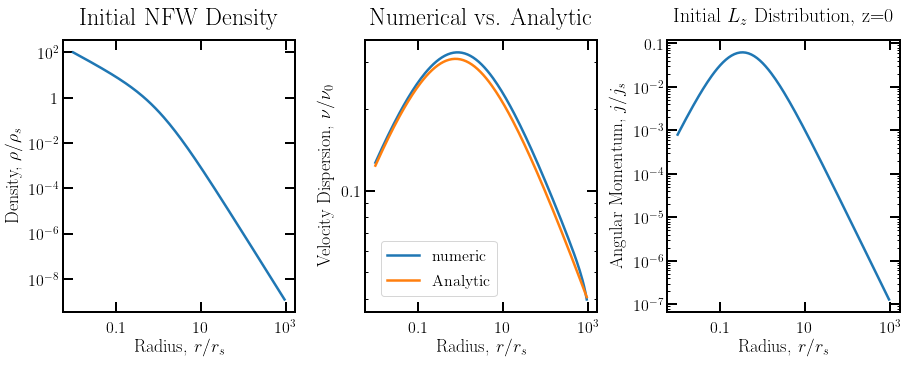

In [590]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5))

axarr[0].loglog()
axarr[0].plot(r,rho_NFW(r))
axarr[0].set_xlabel(r'Radius, $r/r_s$')
axarr[0].set_ylabel(r'Density, $\rho/\rho_s$')
axarr[0].set_title('Initial NFW Density')

axarr[1].loglog()
axarr[1].plot(r,nu, label='numeric')#label=r'$t=\epsilon$')
axarr[1].plot(r,nu_init(r,switch=False), label='Analytic')#label=r'$t=0$')
# axarr[1].plot(r[:20],np.sqrt(4*(r*np.log(1/r))[:20]))
axarr[1].set_xlabel(r'Radius, $r/r_s$')
axarr[1].set_ylabel(r'Velocity Dispersion, $\nu/\nu_0$')
# axarr[1].set_title('Energy Loss')
axarr[1].set_title(r'Numerical vs. Analytic')
axarr[1].legend()

axarr[2].loglog()
axarr[2].plot(r,j_init(r))
axarr[2].set_xlabel(r'Radius, $r/r_s$')
axarr[2].set_ylabel(r'Angular Momentum, $j/j_s$')
axarr[2].set_title('Initial $L_z$ Distribution, z=0', fontsize=20)

plt.subplots_adjust(#top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.3)

In [538]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

diagonals = [r, nu[:-1]]
tmp = csc_matrix(diags(diagonals, [0, -1]))
spsolve(tmp,r)

array([ 1.00000000e+00, -1.01845470e+01,  1.09331463e+02, -1.10474194e+03,
        1.06219545e+04, -9.70492364e+04,  8.42493526e+05, -6.94722508e+06,
        5.44017742e+07, -4.04440022e+08,  2.85373516e+09, -1.91058884e+10,
        1.21335181e+11, -7.30702053e+11,  4.17150040e+12, -2.25685137e+13,
        1.15672096e+14, -5.61463237e+14,  2.58005487e+15, -1.12200528e+16,
        4.61591886e+16, -1.79577993e+17,  6.60403614e+17, -2.29483816e+18,
        7.53183887e+18, -2.33384165e+19,  6.82453681e+19, -1.88239732e+20,
        4.89536876e+20, -1.19974773e+21,  2.76958016e+21, -6.01923234e+21,
        1.23097632e+22, -2.36762279e+22,  4.28052342e+22, -7.27050614e+22,
        1.15950386e+23, -1.73528367e+23,  2.43559481e+23, -3.20417401e+23,
        3.94855879e+23, -4.55514708e+23,  4.91623100e+23, -4.96075941e+23,
        4.67697750e+23, -4.11712779e+23,  3.38175229e+23, -2.59006110e+23,
        1.84840701e+23, -1.22828661e+23,  7.59465941e+22, -4.36628908e+22,
        2.33237791e+22, -

In [540]:
rho[0]*nu[0]**2/r[0]

142.97520110264264

In [545]:
dpdr[10]

-19.90671492353956

In [523]:
dpdr=np.diff(rho*nu**2)/np.diff(r)
print(dpdr+(M*rho/r**2)[1:])

[-2.98427949e-13 -1.13686838e-13  4.97379915e-14 -2.55795385e-13
 -2.48689958e-13  1.52766688e-13 -2.48689958e-14  2.27373675e-13
 -2.09610107e-13 -1.66977543e-13 -5.68434189e-14  3.55271368e-14
 -2.13162821e-14  1.77635684e-14  4.79616347e-14  1.42108547e-14
 -2.84217094e-14  1.06581410e-14 -4.44089210e-14 -1.77635684e-14
  5.68434189e-14 -4.52970994e-14  2.84217094e-14  2.66453526e-15
 -6.21724894e-15  0.00000000e+00  7.10542736e-15  8.88178420e-16
  2.13162821e-14  3.55271368e-15  1.77635684e-15  4.44089210e-15
 -3.10862447e-15  0.00000000e+00 -6.66133815e-15 -3.77475828e-15
 -1.33226763e-15 -5.55111512e-15  2.44249065e-15  4.44089210e-16
 -4.44089210e-16 -2.22044605e-15 -1.33226763e-15  1.77635684e-15
  1.33226763e-15  2.22044605e-16  4.44089210e-16 -6.66133815e-16
 -5.55111512e-17 -8.32667268e-16  4.44089210e-16  3.88578059e-16
 -1.38777878e-16  0.00000000e+00 -8.32667268e-17 -5.55111512e-17
  4.16333634e-17  5.55111512e-17 -1.38777878e-17 -6.24500451e-17
  0.00000000e+00 -4.16333

In [ ]:
def hydrostatic_eq(r,nu,rho,M):
    return 0 

# Something Else

In [61]:
%autoreload

rs_vec = np.flipud(np.arange(5, 3000, 1))

def func(rs):
    
    if isinstance(rs, np.ndarray):
    
        xe_to_return = np.zeros_like(rs)
        xe_to_return[np.where(rs < 7)] = 1

        return xe_to_return
    
    else:
        
        if rs > 7:
            
            return 0
        
        else:
            
            return 1.

test2 = main.evolve(
    start_rs=3000, coarsen_factor=12,
    DM_process='decay', mDM=2e4, lifetime=1e24, primary='phot_delta',
    reion_switch = True, reion_rs = 7, xe_reion_func=func,
    backreaction=False, compute_fs_method='He'
)

1 1 1 [False  True]
0 0 0 [ True  True]


IndexError: index -1 is out of bounds for axis 0 with size 0

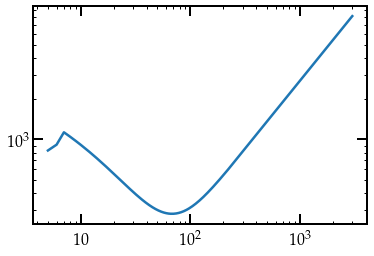

In [51]:
plt.figure()

plt.loglog()

plt.plot(rs_vec, test2[:,0]/phys.kB)

In [53]:
?main.evolve

In [24]:
test

array([[7.04232739e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.04126271e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.03891275e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       ...,
       [9.04744350e-05, 1.90694083e-04, 9.99998695e-13, 9.99998695e-13],
       [6.65100843e-05, 1.88570323e-04, 9.99998695e-13, 9.99998695e-13],
       [4.62064135e-05, 1.86229989e-04, 9.99998695e-13, 9.99998695e-13]])